# Weekly Stock Outperformance Screening for S&P 500

### Project Overview    
Retail investors face a common challenge in short-term trading: identifying which stocks are likely to outperform the broader market over a near-term horizon. While long-term investing tools are widely available, there is limited decision support tailored to weekly positioning strategies.

This project develops a classification-based screening model that evaluates all S&P 500 constituent stocks and identifies those that are likely to outperform the S&P 500 index over the next five trading days. The model is designed as a decision-support tool, not a trading system, to help surface candidates for further analysis.

### Business Understanding
The stakeholder for this project is a retail trading platform that serves individual investors engaged in short-term positioning strategies.    
The platform’s objective is to provide users with a weekly screening feature that highlights stocks with a higher probability of beating the S&P 500 in the upcoming trading week. A key business risk for the platform is failing to surface a stock that ultimately performs well, as missed opportunities reduce user trust and engagement.    
As a result, the modeling approach prioritizes recall of outperforming stocks, even if that means occasionally flagging stocks that do not ultimately outperform.

### Problem Statement
The goal of this project is to build a binary classification model that predicts whether an S&P 500 stock will outperform the S&P 500 index over the next five trading days, using historical price behavior and company-level characteristics.    
Each stock–week observation is labeled as either:
* **Outperform**: stock return exceeds S&P 500 return over the next five trading days
* **Not Outperform**: stock return does not exceed the index return

### Data Description
This project uses publicly available S&P 500 market data sourced from Kaggle, consisting of three primary datasets [S&P 500 Stocks Kaggle Dataset](https://www.kaggle.com/datasets/andrewmvd/sp-500-stocks):
* Stock-level daily price data for all S&P 500 constituents
* Daily S&P 500 index values
* Company metadata, including sector and industry classification      

The data includes over 500 stocks, daily observations, and both numerical and categorical features, making it suitable for a classification task that requires feature engineering and model comparison.

### Project Objectives
* Develop a baseline, interpretable classification model that predicts short-term stock outperformance.    
* Compare linear and nonparametric modeling approaches to evaluate trade-offs between interpretability and flexibility.    
* Deliver a practical weekly screening framework that can be used by a retail trading platform to surface candidate stocks for short-term positioning.    

## 1. Library Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# Scikit-learn
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Scikit-learn: evaluation metrics
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    RocCurveDisplay
)

## 2. Data Loading and Initial Inspection

In [2]:
# Load datasets
stocks_df = pd.read_csv("./sp500_stocks.csv")
index_df = pd.read_csv("./sp500_index.csv")
companies_df = pd.read_csv("./sp500_companies.csv")

In [3]:
# Inspect dataset shapes
print("Stocks data shape:", stocks_df.shape)
print("Index data shape:", index_df.shape)
print("Company metadata shape:", companies_df.shape)

# Review column names and data types
print("\nStocks columns and types:")
stocks_df.info()

print("\nIndex columns and types:")
index_df.info()

print("\nCompany metadata columns and types:")
companies_df.info()

# Preview sample rows
stocks_df.head(), index_df.head(), companies_df.head()

Stocks data shape: (1891536, 8)
Index data shape: (2517, 2)
Company metadata shape: (502, 16)

Stocks columns and types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1891536 entries, 0 to 1891535
Data columns (total 8 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Date       object 
 1   Symbol     object 
 2   Adj Close  float64
 3   Close      float64
 4   High       float64
 5   Low        float64
 6   Open       float64
 7   Volume     float64
dtypes: float64(6), object(2)
memory usage: 115.5+ MB

Index columns and types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2517 entries, 0 to 2516
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2517 non-null   object 
 1   S&P500  2517 non-null   float64
dtypes: float64(1), object(1)
memory usage: 39.5+ KB

Company metadata columns and types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502 entries, 0 to 501
Data columns (total 16 columns)

(         Date Symbol  Adj Close  Close  High  Low  Open  Volume
 0  2010-01-04    MMM        NaN    NaN   NaN  NaN   NaN     NaN
 1  2010-01-05    MMM        NaN    NaN   NaN  NaN   NaN     NaN
 2  2010-01-06    MMM        NaN    NaN   NaN  NaN   NaN     NaN
 3  2010-01-07    MMM        NaN    NaN   NaN  NaN   NaN     NaN
 4  2010-01-08    MMM        NaN    NaN   NaN  NaN   NaN     NaN,
          Date   S&P500
 0  2014-12-22  2078.54
 1  2014-12-23  2082.17
 2  2014-12-24  2081.88
 3  2014-12-26  2088.77
 4  2014-12-29  2090.57,
   Exchange Symbol              Shortname               Longname  \
 0      NMS   AAPL             Apple Inc.             Apple Inc.   
 1      NMS   NVDA     NVIDIA Corporation     NVIDIA Corporation   
 2      NMS   MSFT  Microsoft Corporation  Microsoft Corporation   
 3      NMS   AMZN       Amazon.com, Inc.       Amazon.com, Inc.   
 4      NMS  GOOGL          Alphabet Inc.          Alphabet Inc.   
 
                    Sector                        Indu

## 3. Data Cleaning and Preparation

In [4]:
# 3.1 Date and Index Handling

# Parse dates
stocks_df["Date"] = pd.to_datetime(stocks_df["Date"], errors="coerce")
index_df["Date"] = pd.to_datetime(index_df["Date"], errors="coerce")

# Standardize symbol formatting (defensive)
stocks_df["Symbol"] = stocks_df["Symbol"].astype(str).str.strip().str.upper()
companies_df["Symbol"] = companies_df["Symbol"].astype(str).str.strip().str.upper()

# Drop rows where Date could not be parsed
stocks_df = stocks_df.dropna(subset=["Date"])
index_df = index_df.dropna(subset=["Date"])

# Sort chronologically (and by Symbol for stock data)
stocks_df = stocks_df.sort_values(["Symbol", "Date"]).reset_index(drop=True)
index_df = index_df.sort_values("Date").reset_index(drop=True)

# Ensure consistent date ranges (restrict stock data to index trading dates)
index_dates = set(index_df["Date"].unique())
stocks_df = stocks_df[stocks_df["Date"].isin(index_dates)].copy()

# Quick date-range confirmation
print("Stocks date range:", stocks_df["Date"].min(), "to", stocks_df["Date"].max())
print("Index  date range:", index_df["Date"].min(), "to", index_df["Date"].max())


Stocks date range: 2014-12-22 00:00:00 to 2024-12-20 00:00:00
Index  date range: 2014-12-22 00:00:00 to 2024-12-20 00:00:00


In [5]:
# 3.2 Data Integrity Checks

# 1) Check duplicates in merge keys
dup_stock_keys = stocks_df.duplicated(subset=["Symbol", "Date"]).sum()
dup_index_keys = index_df.duplicated(subset=["Date"]).sum()

print("Duplicate (Symbol, Date) rows in stocks_df:", dup_stock_keys)
print("Duplicate (Date) rows in index_df:", dup_index_keys)

# If duplicates exist, keep the last record (safe default)
if dup_stock_keys > 0:
    stocks_df = stocks_df.drop_duplicates(subset=["Symbol", "Date"], keep="last").copy()

if dup_index_keys > 0:
    index_df = index_df.drop_duplicates(subset=["Date"], keep="last").copy()

# 2) Missing / invalid values in stock prices
price_cols = ["Adj Close", "Close", "High", "Low", "Open", "Volume"]
missing_summary = stocks_df[price_cols].isna().mean().sort_values(ascending=False)

print("\nMissing rate by column (stocks_df):")
print(missing_summary)

# Drop rows where the core pricing fields are fully missing (your earlier sample had these)
stocks_df = stocks_df.dropna(subset=["Adj Close", "Close", "Open", "High", "Low"])

# 3) Basic sanity checks (non-negative price, non-negative volume)
stocks_df = stocks_df[
    (stocks_df["Adj Close"] > 0) &
    (stocks_df["Close"] > 0) &
    (stocks_df["Open"] > 0) &
    (stocks_df["High"] > 0) &
    (stocks_df["Low"] > 0) &
    (stocks_df["Volume"].fillna(0) >= 0)
].copy()

# 4) Key overlap checks (symbols)
stock_symbols = set(stocks_df["Symbol"].unique())
company_symbols = set(companies_df["Symbol"].unique())

print("\nUnique symbols in stocks_df:", len(stock_symbols))
print("Unique symbols in companies_df:", len(company_symbols))
print("Symbols overlap:", len(stock_symbols.intersection(company_symbols)))

# Optional: keep only stocks that exist in company metadata (helps when adding Sector later)
stocks_df = stocks_df[stocks_df["Symbol"].isin(company_symbols)].copy()

print("\nFinal cleaned shapes:")
print("stocks_df:", stocks_df.shape)
print("index_df :", index_df.shape)
print("companies_df:", companies_df.shape)

Duplicate (Symbol, Date) rows in stocks_df: 0
Duplicate (Date) rows in index_df: 0

Missing rate by column (stocks_df):
Adj Close    0.664958
Close        0.664958
High         0.664958
Low          0.664958
Open         0.664958
Volume       0.664958
dtype: float64

Unique symbols in stocks_df: 172
Unique symbols in companies_df: 502
Symbols overlap: 172

Final cleaned shapes:
stocks_df: (423337, 8)
index_df : (2517, 2)
companies_df: (502, 16)


### 4. Exploratory Data Analysis (EDA)

In [6]:
# 4.1 Data Quality Assessment

# How many observations per symbol? (helps spot thin histories / survivorship issues)
obs_per_symbol = stocks_df.groupby("Symbol").size().describe()
print("Observations per symbol (summary):")
print(obs_per_symbol)

# Quick scan of extreme returns using Adj Close (heavy tails are normal, but we check for crazy values)
tmp = stocks_df.sort_values(["Symbol", "Date"]).copy()
tmp["ret_1d"] = tmp.groupby("Symbol")["Adj Close"].pct_change()

print("\nDaily return quantiles (Adj Close):")
print(tmp["ret_1d"].dropna().quantile([0.001, 0.01, 0.05, 0.5, 0.95, 0.99, 0.999]))

Observations per symbol (summary):
count     172.000000
mean     2461.261628
std       287.306927
min       185.000000
25%      2517.000000
50%      2517.000000
75%      2517.000000
max      2517.000000
dtype: float64

Daily return quantiles (Adj Close):
0.001   -0.122367
0.010   -0.055878
0.050   -0.028826
0.500    0.000818
0.950    0.029011
0.990    0.056584
0.999    0.131149
Name: ret_1d, dtype: float64


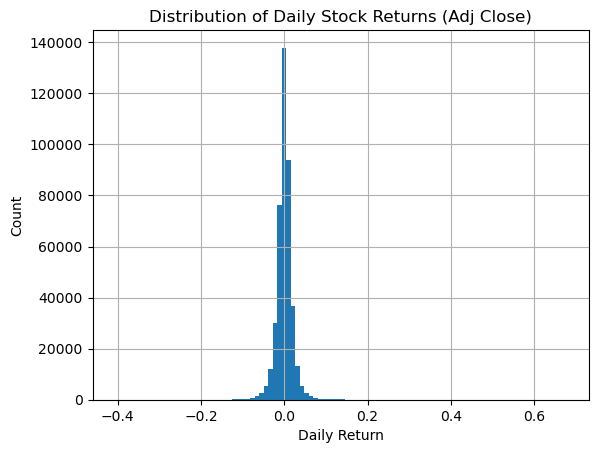

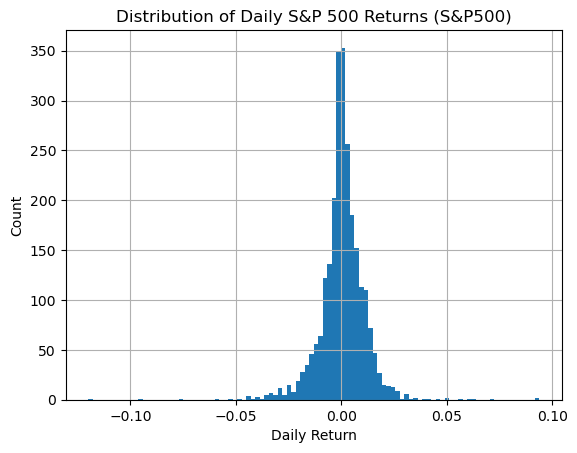

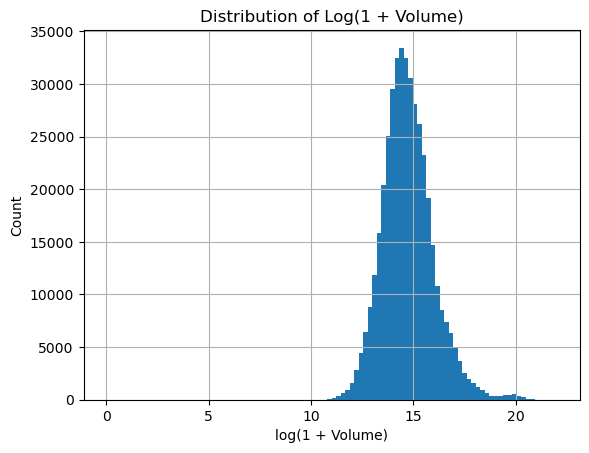

In [7]:
# 4.2 Market and Stock Behavior (Fixed for index_df column names)

stocks_tmp = stocks_df.sort_values(["Symbol", "Date"]).copy()
index_tmp  = index_df.sort_values("Date").copy()

# Stock daily returns (Adj Close is correct for stocks)
stocks_tmp["ret_1d"] = stocks_tmp.groupby("Symbol")["Adj Close"].pct_change()

# Detect the index price column (since index_df usually doesn't use "Adj Close")
possible_index_price_cols = ["Adj Close", "Close", "S&P500", "SP500", "Index", "Value"]
index_price_col = next((c for c in possible_index_price_cols if c in index_tmp.columns), None)

if index_price_col is None:
    raise KeyError(f"Could not find index price column. Available columns: {list(index_tmp.columns)}")

# Index daily returns
index_tmp["ret_1d"] = index_tmp[index_price_col].pct_change()

# Volume behavior (log scale because Volume is skewed)
stocks_tmp["log_volume"] = np.log1p(stocks_tmp["Volume"])

# Distributions
stocks_tmp["ret_1d"].dropna().hist(bins=100)
plt.title("Distribution of Daily Stock Returns (Adj Close)")
plt.xlabel("Daily Return")
plt.ylabel("Count")
plt.show()

index_tmp["ret_1d"].dropna().hist(bins=100)
plt.title(f"Distribution of Daily S&P 500 Returns ({index_price_col})")
plt.xlabel("Daily Return")
plt.ylabel("Count")
plt.show()

stocks_tmp["log_volume"].dropna().hist(bins=100)
plt.title("Distribution of Log(1 + Volume)")
plt.xlabel("log(1 + Volume)")
plt.ylabel("Count")
plt.show()

The histogram Distribution of Daily Stock Returns (Adj Close) shows that most stocks experience very small daily price changes, with large positive or negative moves occurring infrequently, resulting in a sharp peak around zero and long tails.

The histogram Distribution of Daily S&P 500 Returns shows that index returns are more tightly concentrated around zero, reflecting lower volatility and fewer extreme movements compared to individual stocks.

The histogram Distribution of Log(1 + Volume) shows that applying a log transformation reduces extreme skew in trading volume, producing a more balanced distribution that is easier to model.

Index price column used: S&P500

Class balance (0=not outperform, 1=outperform):
outperform_5d
0    0.49318
1    0.50682
Name: proportion, dtype: float64


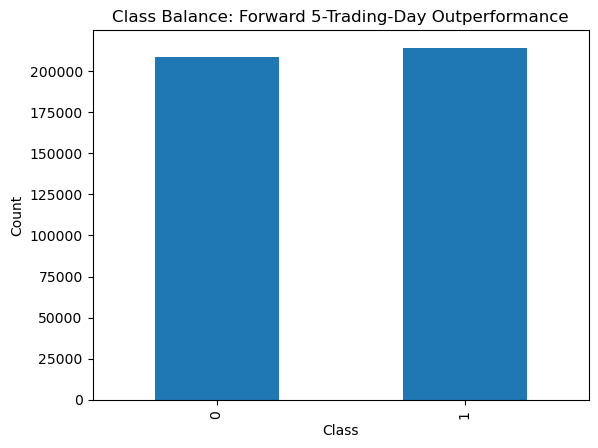

In [8]:
# 4.3 Class Balance Exploration (calendar-aligned 5-trading-day forward window)

# Detect the index price column (index_df usually doesn't use "Adj Close")
possible_index_price_cols = ["Adj Close", "Close", "S&P500", "SP500", "Index", "Value"]
index_price_col = next((c for c in possible_index_price_cols if c in index_df.columns), None)

if index_price_col is None:
    raise KeyError(f"Could not find index price column. Available columns: {list(index_df.columns)}")

# Build trading calendar from index dates and map each day -> day + 5 trading sessions
cal = index_df[["Date"]].drop_duplicates().sort_values("Date").reset_index(drop=True)
cal["Date_plus_5"] = cal["Date"].shift(-5)

# Attach Date_plus_5 to stocks and index
s = stocks_df.merge(cal, on="Date", how="left")
i = index_df.merge(cal, on="Date", how="left")

# Future prices for stocks (per symbol) and index (single series)
s_fut = stocks_df[["Symbol", "Date", "Adj Close"]].rename(
    columns={"Date": "Date_plus_5", "Adj Close": "AdjClose_t5"}
)
i_fut = index_df[["Date", index_price_col]].rename(
    columns={"Date": "Date_plus_5", index_price_col: "IndexPrice_t5"}
)

# Merge future prices
s = s.merge(s_fut, on=["Symbol", "Date_plus_5"], how="left")
i = i.merge(i_fut, on="Date_plus_5", how="left")

# Forward 5-trading-day returns
s["fwd_ret_5d"] = (s["AdjClose_t5"] / s["Adj Close"]) - 1
i["index_fwd_ret_5d"] = (i["IndexPrice_t5"] / i[index_price_col]) - 1

# Join index forward return onto each stock-date
eda_df = s.merge(i[["Date", "index_fwd_ret_5d"]], on="Date", how="left")

# Label: 1 if stock beats index over the next 5 trading sessions
eda_df["outperform_5d"] = (eda_df["fwd_ret_5d"] > eda_df["index_fwd_ret_5d"]).astype(int)

# Drop rows where forward window doesn't exist / missing future prices
eda_df = eda_df.dropna(subset=["fwd_ret_5d", "index_fwd_ret_5d"])

# Class balance outputs
print("Index price column used:", index_price_col)
print("\nClass balance (0=not outperform, 1=outperform):")
print(eda_df["outperform_5d"].value_counts(normalize=True).sort_index())

eda_df["outperform_5d"].value_counts().sort_index().plot(kind="bar")
plt.title("Class Balance: Forward 5-Trading-Day Outperformance")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

The bar chart shows that the dataset is well balanced, with stocks outperforming the S&P 500 over the next five trading days about 50.7% of the time and underperforming about 49.3% of the time, indicating no strong class imbalance.

Outperformance rate by sector:
Sector
Technology                0.523775
Industrials               0.513128
Financial Services        0.511322
Consumer Cyclical         0.510284
Healthcare                0.507081
Communication Services    0.500589
Utilities                 0.495267
Real Estate               0.495222
Basic Materials           0.492948
Consumer Defensive        0.489285
Energy                    0.488455
Name: outperform_5d, dtype: float64


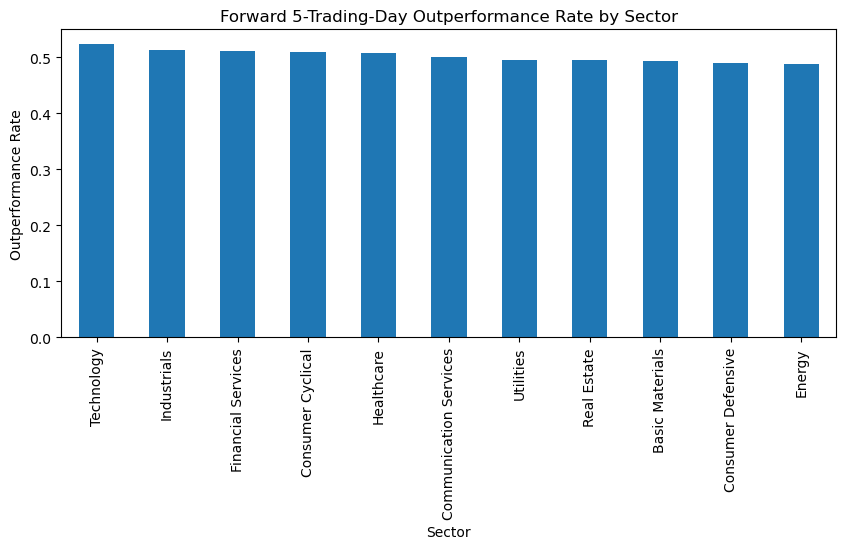

In [9]:
# 4.4 Sector-Level Exploration (Sector only)

# Add sector
eda_df = eda_df.merge(companies_df[["Symbol", "Sector"]], on="Symbol", how="left")

# Outperformance rate by sector
sector_rates = (
    eda_df.groupby("Sector")["outperform_5d"]
    .mean()
    .sort_values(ascending=False)
)

print("Outperformance rate by sector:")
print(sector_rates)

sector_rates.plot(kind="bar", figsize=(10, 4))
plt.title("Forward 5-Trading-Day Outperformance Rate by Sector")
plt.xlabel("Sector")
plt.ylabel("Outperformance Rate")
plt.show()

The chart shows that outperformance rates are fairly similar across sectors, with Technology, Industrials, and Financial Services slightly more likely to beat the index over a 5-trading-day window, while Energy and Consumer Defensive sectors underperform marginally more often, indicating modest sector effects rather than strong dominance.

## 5. Feature Engineering

In [10]:
# 5.1 Price-Based Features

# Ensure proper ordering
stocks_feat = stocks_df.sort_values(["Symbol", "Date"]).copy()

# Daily returns (lagged information)
stocks_feat["ret_1d"] = stocks_feat.groupby("Symbol")["Adj Close"].pct_change()

# Rolling returns (momentum-style)
stocks_feat["ret_5d"]  = stocks_feat.groupby("Symbol")["Adj Close"].pct_change(periods=5)
stocks_feat["ret_10d"] = stocks_feat.groupby("Symbol")["Adj Close"].pct_change(periods=10)

# Rolling volatility (risk / uncertainty)
stocks_feat["vol_5d"]  = stocks_feat.groupby("Symbol")["ret_1d"].rolling(5).std().reset_index(level=0, drop=True)
stocks_feat["vol_10d"] = stocks_feat.groupby("Symbol")["ret_1d"].rolling(10).std().reset_index(level=0, drop=True)

# Simple momentum indicators (price relative to moving average)
stocks_feat["ma_5"]  = stocks_feat.groupby("Symbol")["Adj Close"].rolling(5).mean().reset_index(level=0, drop=True)
stocks_feat["ma_10"] = stocks_feat.groupby("Symbol")["Adj Close"].rolling(10).mean().reset_index(level=0, drop=True)

stocks_feat["price_vs_ma5"]  = (stocks_feat["Adj Close"] / stocks_feat["ma_5"]) - 1
stocks_feat["price_vs_ma10"] = (stocks_feat["Adj Close"] / stocks_feat["ma_10"]) - 1

In [11]:
# 5.2 Relative Performance Features

# Detect index price column (reuse the robust logic)
possible_index_price_cols = ["Adj Close", "Close", "S&P500", "SP500", "Index", "Value"]
index_price_col = next((c for c in possible_index_price_cols if c in index_df.columns), None)

if index_price_col is None:
    raise KeyError(f"Index price column not found. Available columns: {list(index_df.columns)}")

# Prepare index returns
index_feat = index_df.sort_values("Date").copy()
index_feat["index_ret_1d"]  = index_feat[index_price_col].pct_change()
index_feat["index_ret_5d"]  = index_feat[index_price_col].pct_change(periods=5)
index_feat["index_ret_10d"] = index_feat[index_price_col].pct_change(periods=10)

# Merge index features onto stock data by Date
stocks_feat = stocks_feat.merge(
    index_feat[["Date", "index_ret_1d", "index_ret_5d", "index_ret_10d"]],
    on="Date",
    how="left"
)

# Excess (relative) performance features
stocks_feat["excess_ret_1d"]  = stocks_feat["ret_1d"]  - stocks_feat["index_ret_1d"]
stocks_feat["excess_ret_5d"]  = stocks_feat["ret_5d"]  - stocks_feat["index_ret_5d"]
stocks_feat["excess_ret_10d"] = stocks_feat["ret_10d"] - stocks_feat["index_ret_10d"]

In [12]:
# 5.3 Categorical Feature Encoding

# Merge sector information
stocks_feat = stocks_feat.merge(
    companies_df[["Symbol", "Sector"]],
    on="Symbol",
    how="left"
)

# Confirm sector coverage
print("Missing sector rate:", stocks_feat["Sector"].isna().mean())

# One-hot encoding for sector (safe, interpretable)
stocks_feat = pd.get_dummies(
    stocks_feat,
    columns=["Sector"],
    drop_first=True
)

Missing sector rate: 0.0


In [13]:
# Final feature check before target merge and modeling

feature_cols = [
    "ret_1d", "ret_5d", "ret_10d",
    "vol_5d", "vol_10d",
    "price_vs_ma5", "price_vs_ma10",
    "excess_ret_1d", "excess_ret_5d", "excess_ret_10d"
]

stocks_feat[feature_cols].isna().mean().sort_values(ascending=False)


vol_10d           0.004063
ret_10d           0.004063
excess_ret_10d    0.004063
price_vs_ma10     0.003657
excess_ret_5d     0.002031
ret_5d            0.002031
vol_5d            0.002031
price_vs_ma5      0.001625
ret_1d            0.000406
excess_ret_1d     0.000406
dtype: float64

In [14]:
stocks_feat.shape

(423337, 33)

## 6. Target Variable Construction

In [15]:
# 6.1 Forward Return Calculation (calendar-aligned 5 trading days)

# Detect index price column (robust)
possible_index_price_cols = ["Adj Close", "Close", "S&P500", "SP500", "Index", "Value"]
index_price_col = next((c for c in possible_index_price_cols if c in index_df.columns), None)

if index_price_col is None:
    raise KeyError(f"Index price column not found. Available columns: {list(index_df.columns)}")

# Build master trading calendar from index dates
cal = index_df[["Date"]].drop_duplicates().sort_values("Date").reset_index(drop=True)
cal["Date_plus_5"] = cal["Date"].shift(-5)

# Attach forward-date mapping
stocks_tgt = stocks_feat.merge(cal, on="Date", how="left")
index_tgt  = index_df.merge(cal, on="Date", how="left")

# Bring forward prices
stock_fwd = stocks_df[["Symbol", "Date", "Adj Close"]].rename(
    columns={"Date": "Date_plus_5", "Adj Close": "AdjClose_t5"}
)
index_fwd = index_df[["Date", index_price_col]].rename(
    columns={"Date": "Date_plus_5", index_price_col: "IndexPrice_t5"}
)

stocks_tgt = stocks_tgt.merge(stock_fwd, on=["Symbol", "Date_plus_5"], how="left")
index_tgt  = index_tgt.merge(index_fwd, on="Date_plus_5", how="left")

# Compute forward 5-trading-day returns
stocks_tgt["stock_fwd_ret_5d"] = (stocks_tgt["AdjClose_t5"] / stocks_tgt["Adj Close"]) - 1
index_tgt["index_fwd_ret_5d"]  = (index_tgt["IndexPrice_t5"] / index_tgt[index_price_col]) - 1

# Merge index forward return onto stock-level data
stocks_tgt = stocks_tgt.merge(
    index_tgt[["Date", "index_fwd_ret_5d"]],
    on="Date",
    how="left"
)


In [16]:
# 6.2 Binary Target Definition

# Binary target: 1 if stock outperforms index over next 5 trading days
stocks_tgt["target_outperform_5d"] = (
    stocks_tgt["stock_fwd_ret_5d"] > stocks_tgt["index_fwd_ret_5d"]
).astype(int)

# Drop rows where forward returns are unavailable (end-of-calendar or short history)
stocks_tgt = stocks_tgt.dropna(
    subset=["stock_fwd_ret_5d", "index_fwd_ret_5d"]
).reset_index(drop=True)

In [17]:
# 6.3 Target Validation

# Target balance check
print("Target class balance:")
print(stocks_tgt["target_outperform_5d"].value_counts(normalize=True).sort_index())

# Sanity check: average forward returns by class
print("\nMean forward returns by class:")
print(
    stocks_tgt.groupby("target_outperform_5d")[["stock_fwd_ret_5d", "index_fwd_ret_5d"]].mean()
)

Target class balance:
target_outperform_5d
0    0.49318
1    0.50682
Name: proportion, dtype: float64

Mean forward returns by class:
                      stock_fwd_ret_5d  index_fwd_ret_5d
target_outperform_5d                                    
0                            -0.022207          0.002894
1                             0.028057          0.001867


In [18]:
# 6.4 Final Modeling Dataset

# Drop remaining rows with missing feature values (from rolling windows)
model_df = stocks_tgt.dropna().reset_index(drop=True)

print("Final modeling dataset shape:", model_df.shape)

Final modeling dataset shape: (420757, 38)


## 7. Train-Test Split Strategy

In [19]:
# 7.1 Time-Aware Data Splitting

# Ensure chronological ordering
model_df = model_df.sort_values("Date").reset_index(drop=True)

# Define time-based split (last 20% of dates held out)
split_date = model_df["Date"].quantile(0.80)

print("Train/Test split date:", split_date)

# Create train and test sets
train_df = model_df[model_df["Date"] <= split_date].copy()
test_df  = model_df[model_df["Date"] > split_date].copy()

print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)

Train/Test split date: 2022-12-29 00:00:00
Train shape: (336655, 38)
Test shape : (84102, 38)


In [20]:
# 7.2 Feature Matrix and Target

# Define target
target_col = "target_outperform_5d"

# Columns excluded from modeling
exclude_cols = [
    "Date",
    "Symbol",
    target_col,
    "stock_fwd_ret_5d",
    "index_fwd_ret_5d"
]

# Feature columns
feature_cols = [c for c in train_df.columns if c not in exclude_cols]

# Split into X and y
X_train = train_df[feature_cols]
y_train = train_df[target_col]

X_test = test_df[feature_cols]
y_test = test_df[target_col]

print("Number of features:", len(feature_cols))
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test :", X_test.shape,  "y_test :", y_test.shape)

Number of features: 33
X_train: (336655, 33) y_train: (336655,)
X_test : (84102, 33) y_test : (84102,)


## 8. Baseline Model: Logistic Regression

In [21]:
# 8.1 Logistic Regression Training 

# 1) Identify and drop non-numeric columns (datetimes + objects)
dt_cols = X_train.select_dtypes(include=["datetime64[ns]"]).columns
obj_cols = X_train.select_dtypes(include=["object"]).columns

print("Datetime columns dropped:", list(dt_cols))
print("Object columns dropped  :", list(obj_cols))

X_train_lr = X_train.drop(columns=list(dt_cols) + list(obj_cols)).copy()
X_test_lr  = X_test.drop(columns=list(dt_cols) + list(obj_cols)).copy()

# 2) Convert booleans to integers (safe for sklearn)
bool_cols = X_train_lr.select_dtypes(include="bool").columns
X_train_lr[bool_cols] = X_train_lr[bool_cols].astype(int)
X_test_lr[bool_cols]  = X_test_lr[bool_cols].astype(int)

# 3) Final sanity check: everything must be numeric now
print("Remaining dtypes (should be only numeric/bool->int):")
print(X_train_lr.dtypes.value_counts())

# 4) Pipeline: scaling + logistic regression
logreg_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        max_iter=2000,
        solver="lbfgs",
        random_state=42
    ))
])

# 5) Fit
logreg_pipeline.fit(X_train_lr, y_train)

Datetime columns dropped: ['Date_plus_5']
Object columns dropped  : []
Remaining dtypes (should be only numeric/bool->int):
float64    22
int64      10
Name: count, dtype: int64


Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg', LogisticRegression(max_iter=2000, random_state=42))])

In [22]:
# 8.2 Logistic Regression Evaluation

from sklearn.metrics import classification_report, roc_auc_score

y_pred = logreg_pipeline.predict(X_test_lr)
y_prob = logreg_pipeline.predict_proba(X_test_lr)[:, 1]

print(classification_report(y_test, y_pred, digits=4))
print("ROC-AUC:", round(roc_auc_score(y_test, y_prob), 4))

              precision    recall  f1-score   support

           0     0.8624    0.7508    0.8028     43731
           1     0.7633    0.8703    0.8133     40371

    accuracy                         0.8082     84102
   macro avg     0.8129    0.8105    0.8080     84102
weighted avg     0.8148    0.8082    0.8078     84102

ROC-AUC: 0.8846


<Figure size 500x400 with 0 Axes>

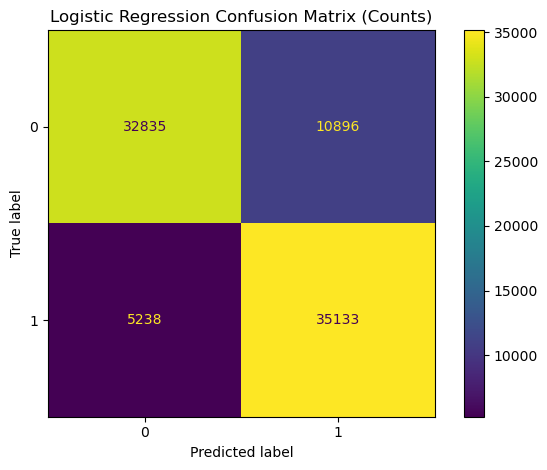

<Figure size 500x400 with 0 Axes>

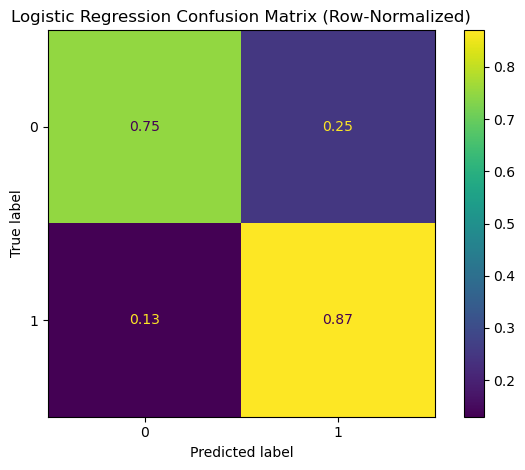

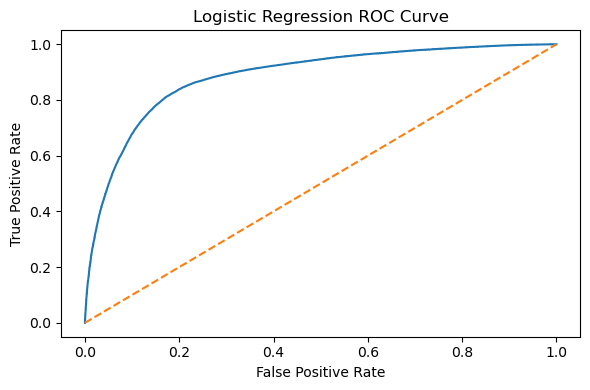

In [ ]:
# 8.3 VISUALS: Confusion matrix + ROC curve (Logistic Regression)

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay

# Predict labels + probabilities
y_pred = logreg_pipeline.predict(X_test_lr)
y_proba = logreg_pipeline.predict_proba(X_test_lr)[:, 1]

# --- 1) Confusion matrix (counts) ---
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

plt.figure(figsize=(5, 4))
disp.plot(values_format="d")
plt.title("Logistic Regression Confusion Matrix (Counts)")
plt.tight_layout()
plt.show();

# --- 2) Confusion matrix (normalized) ---
cm_norm = confusion_matrix(y_test, y_pred, labels=[0, 1], normalize="true")
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=[0, 1])

plt.figure(figsize=(5, 4))
disp_norm.plot(values_format=".2f")
plt.title("Logistic Regression Confusion Matrix (Row-Normalized)")
plt.tight_layout()
plt.show();

# --- 3) ROC curve ---
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("Logistic Regression ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.tight_layout()
plt.show();

The Logistic Regression Confusion Matrix (Counts) shows how many predictions fall into each outcome category. The high number of true positives indicates that the model successfully captures most stocks that go on to outperform the market, which supports its use as a recall-oriented screening tool.

The row-normalized Logistic Regression Confusion Matrix highlights performance within each true class. About 87% of actual outperformers are correctly identified, while underperformers are more likely to be flagged as positives, reflecting a deliberate trade-off that favors minimizing missed outperforming stocks.

The Logistic Regression ROC Curve demonstrates the model’s ability to separate outperforming from non-outperforming stocks across probability thresholds. The curve’s strong lift above the diagonal indicates meaningful ranking power, making the predicted probabilities useful for prioritizing weekly stock candidates.

## 9. Decision Tree

In [23]:
# 9.1 Decision Tree - Initial Training

# Initialize a simple, unconstrained decision tree
dt_model = DecisionTreeClassifier(
    random_state=42
)

# Fit the model
dt_model.fit(X_train_lr, y_train)

DecisionTreeClassifier(random_state=42)

In [24]:
# 9.2 Decision Tree Evaluation

from sklearn.metrics import classification_report, roc_auc_score

# Predictions
y_pred_dt = dt_model.predict(X_test_lr)
y_prob_dt = dt_model.predict_proba(X_test_lr)[:, 1]

# Performance metrics
print(classification_report(y_test, y_pred_dt, digits=4))
print("ROC-AUC:", round(roc_auc_score(y_test, y_prob_dt), 4))

# Overfitting check
print("\nTraining accuracy:", round(dt_model.score(X_train_lr, y_train), 4))
print("Test accuracy    :", round(dt_model.score(X_test_lr, y_test), 4))

              precision    recall  f1-score   support

           0     0.7621    0.6934    0.7261     43731
           1     0.6974    0.7655    0.7299     40371

    accuracy                         0.7280     84102
   macro avg     0.7298    0.7295    0.7280     84102
weighted avg     0.7310    0.7280    0.7279     84102

ROC-AUC: 0.7295

Training accuracy: 1.0
Test accuracy    : 0.728


## 10. Decision Tree Hyperparameter Tuning and Pruning

10.1 Motivation for Tuning

The initial decision tree severely overfit the training data, achieving perfect training accuracy but substantially worse test performance.
Hyperparameter tuning and pruning are applied to control model complexity, improve generalization, and fairly assess whether nonlinear structure provides value beyond the linear baseline.

In [25]:
# 10.2 Decision Tree Hyperparameter Grid

from sklearn.model_selection import GridSearchCV

param_grid = {
    "max_depth": [3, 5, 7, 10, None],
    "min_samples_leaf": [50, 100, 250, 500],
    "min_samples_split": [100, 250, 500]
}

In [26]:
# 10.3 Grid Search (Recall-focused)

dt_base = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=dt_base,
    param_grid=param_grid,
    scoring="recall",
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_lr, y_train)

print("Best parameters found:")
print(grid_search.best_params_)


Fitting 3 folds for each of 60 candidates, totalling 180 fits
Best parameters found:
{'max_depth': 7, 'min_samples_leaf': 50, 'min_samples_split': 500}


In [27]:
# 10.4 Tuned Decision Tree Evaluation

from sklearn.metrics import classification_report, roc_auc_score

best_dt = grid_search.best_estimator_

# Predictions
y_pred_tuned = best_dt.predict(X_test_lr)
y_prob_tuned = best_dt.predict_proba(X_test_lr)[:, 1]

# Metrics
print(classification_report(y_test, y_pred_tuned, digits=4))
print("ROC-AUC:", round(roc_auc_score(y_test, y_prob_tuned), 4))

# Overfitting check
print("\nTraining accuracy:", round(best_dt.score(X_train_lr, y_train), 4))
print("Test accuracy    :", round(best_dt.score(X_test_lr, y_test), 4))

              precision    recall  f1-score   support

           0     0.8220    0.0579    0.1081     43731
           1     0.4915    0.9864    0.6561     40371

    accuracy                         0.5036     84102
   macro avg     0.6567    0.5221    0.3821     84102
weighted avg     0.6633    0.5036    0.3711     84102

ROC-AUC: 0.5506

Training accuracy: 0.5467
Test accuracy    : 0.5036
